In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score#, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
  
from sklearn.linear_model import LinearRegression

import random 

### Dataset

In [2]:
pokemon = pd.read_csv("data/pokemon.csv") 
pokemon = pokemon.rename(index=str, columns={"#": "index"})

combat = pd.read_csv("data/combats.csv")

In [3]:
# w pierwszym zbiorze, pokemon.csv sa zawarte wszystkie pokemonwy wraz z ich statystykami
pokemon.head()

,index,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [4]:
# w combats.csv sa podane dwa id pokemonów które walczą i zwycięzca
combat.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [5]:
print('Pokemon shape: ', pokemon.shape)
print('Combat shape: ', combat.shape)

Pokemon shape:  (800, 12)
Combat shape:  (50000, 3)


In [6]:
print('Pokemon info :')
pokemon.info()
print('\nCombat info :')
combat.info()

Pokemon info :
<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 0 to 799
Data columns (total 12 columns):
index         800 non-null int64
Name          799 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(8), object(3)
memory usage: 75.8+ KB

Combat info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
First_pokemon     50000 non-null int64
Second_pokemon    50000 non-null int64
Winner            50000 non-null int64
dtypes: int64(3)
memory usage: 1.1 MB


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

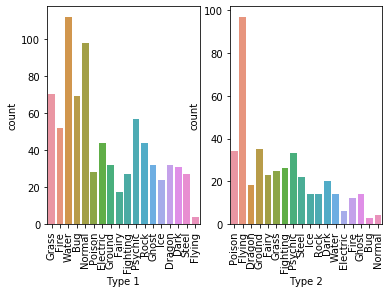

In [7]:
plt.subplot(1,2,1)
sns.countplot(x = 'Type 1', data = pokemon);
plt.xticks(rotation = 90)
plt.subplot(1,2,2)
sns.countplot(x = 'Type 2', data = pokemon);
plt.xticks(rotation = 90)


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

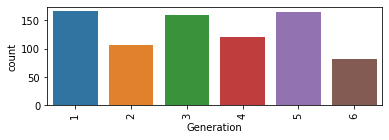

In [8]:
plt.subplot(2,1,1)
sns.countplot(x = 'Generation', data = pokemon)
plt.xticks(rotation = 90)

### Znaleźć i zastąpić Nulla

In [9]:
pokemon.isnull().sum()

index           0
Name            1
Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [10]:
pokemon['Name'][62] = "Primeape" #Dodana nazwa brakującemu pokemonowi

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Zliczenie wygranych oraz rozegranych meczy 
#### by później policzyć procent wygranych dla każdego pokemona

In [11]:
#Zliczenie ile każdy pokemon walczył
FirstPokCombat = combat.First_pokemon.value_counts().reset_index(name = 'FirstPokCombat')
SecondPokCombat = combat.Second_pokemon.value_counts().reset_index(name = 'SecondPokCombat')
TotalCombat = pd.merge(FirstPokCombat, SecondPokCombat, how = 'left', on = 'index')
TotalCombat['TotalMatch'] = TotalCombat['FirstPokCombat']+TotalCombat['SecondPokCombat']
TotalCombat.sort_values('index').head()

,index,FirstPokCombat,SecondPokCombat,TotalMatch
181,1,70,63,133
686,2,55,66,121
238,3,68,64,132
442,4,62,63,125
755,5,50,62,112


In [12]:
#Zliczenie ile razy pokemon wygrał
FirstPokWin = combat['First_pokemon'][combat['First_pokemon'] == combat['Winner']].value_counts().reset_index(name = 'FirstPokWin')
SecondPokWin = combat['Second_pokemon'][combat['Second_pokemon'] == combat['Winner']].value_counts().reset_index(name = 'SecondPokWin')
TotalWin = pd.merge(FirstPokWin, SecondPokWin, how  = 'left', on = 'index')
TotalWin['TotalWin'] = TotalWin['FirstPokWin']+ TotalWin['SecondPokWin']
TotalWin.head(5)

,index,FirstPokWin,SecondPokWin,TotalWin
0,163,81,71,152
1,133,71,53,124
2,164,71,54,125
3,513,70,46,116
4,20,69,46,115


### Połączenie obu tabel

In [13]:
all_data = pd.merge(pokemon, TotalCombat, how = 'left', left_on= 'index', right_on = 'index')
all_data = pd.merge(all_data, TotalWin, how = 'left', on = 'index')

all_data.head(5)

,index,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,FirstPokCombat,SecondPokCombat,TotalMatch,FirstPokWin,SecondPokWin,TotalWin
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,70.0,63.0,133.0,12.0,25.0,37.0
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,55.0,66.0,121.0,20.0,26.0,46.0
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,68.0,64.0,132.0,43.0,46.0,89.0
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,62.0,63.0,125.0,36.0,34.0,70.0
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,50.0,62.0,112.0,24.0,31.0,55.0


In [14]:
all_data.shape

(800, 18)

## Procent Wygranych meczy dla każdego pokemona

In [15]:
pd.set_option('precision', 6)#dodanie 6 wartości po przecinku
all_data['WinPercentage'] = (all_data.TotalWin / all_data.TotalMatch)# * 100
all_data.head(5)

,index,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,FirstPokCombat,SecondPokCombat,TotalMatch,FirstPokWin,SecondPokWin,TotalWin,WinPercentage
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,70.0,63.0,133.0,12.0,25.0,37.0,0.278195
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,55.0,66.0,121.0,20.0,26.0,46.0,0.380165
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,68.0,64.0,132.0,43.0,46.0,89.0,0.674242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,62.0,63.0,125.0,36.0,34.0,70.0,0.560000
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False,50.0,62.0,112.0,24.0,31.0,55.0,0.491071


### Wykresy

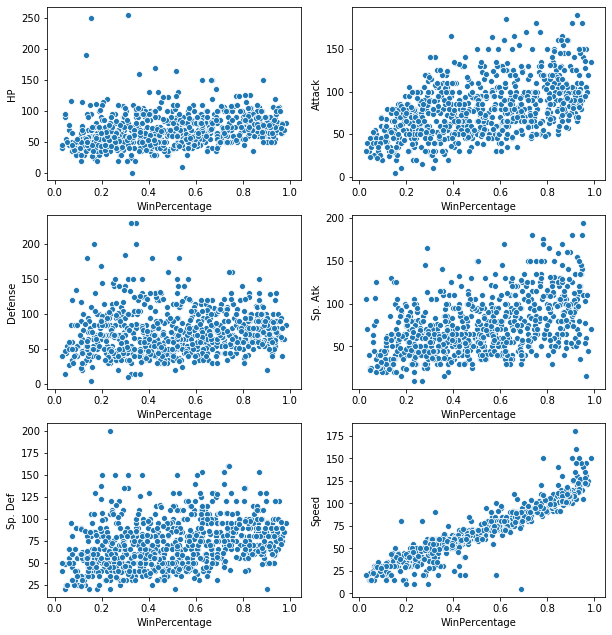

In [16]:
columns = ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed']
plt.figure(figsize = (10,30))
i =0
for col in columns:
    plt.subplot(8,2,i+1)
    sns.scatterplot(x = 'WinPercentage', y = col, data = all_data)
    i+=1
plt.show()

Text(0.5, 1.0, 'Speed vs Win Percentage')

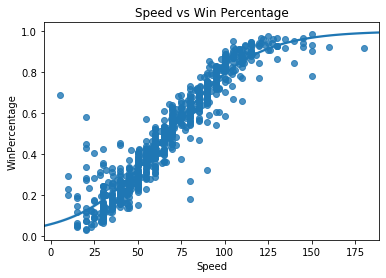

In [17]:
sns.regplot(x="Speed", y="WinPercentage", data=all_data, logistic=True).set_title("Speed vs Win Percentage")

> Jak widać w powyższych wykresów atak i szybkość mają duży wpływ na procent wygranych danego pokemona

## Usuniecie pokemonów ktorych nie walczyły lub nie wygrały

In [18]:
all_data[all_data['WinPercentage'].isnull()]

,index,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,FirstPokCombat,SecondPokCombat,TotalMatch,FirstPokWin,SecondPokWin,TotalWin,WinPercentage
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,144,Ditto,Normal,NaN,48,48,48,48,48,48,1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
189,190,Togepi,Fairy,NaN,35,20,65,40,65,20,2,False,58.0,64.0,122.0,NaN,NaN,NaN,NaN
230,231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False,72.0,63.0,135.0,NaN,NaN,NaN,NaN


In [19]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 799
Data columns (total 19 columns):
index              800 non-null int64
Name               800 non-null object
Type 1             800 non-null object
Type 2             414 non-null object
HP                 800 non-null int64
Attack             800 non-null int64
Defense            800 non-null int64
Sp. Atk            800 non-null int64
Sp. Def            800 non-null int64
Speed              800 non-null int64
Generation         800 non-null int64
Legendary          800 non-null bool
FirstPokCombat     784 non-null float64
SecondPokCombat    784 non-null float64
TotalMatch         784 non-null float64
FirstPokWin        779 non-null float64
SecondPokWin       779 non-null float64
TotalWin           779 non-null float64
WinPercentage      779 non-null float64
dtypes: bool(1), float64(7), int64(8), object(3)
memory usage: 119.5+ KB


In [20]:
#trzeba zamienic puste pola przy'Type 2' by można było usunąć zbędne dane 
all_data['Type 2'].fillna('NO TYPE', inplace = True) 

In [21]:
print('Shape before drop:', all_data.shape)
all_data = all_data.dropna()
print('Shape after drop: ', all_data.shape)

Shape before drop: (800, 19)
Shape after drop:  (779, 19)


In [22]:
all_data.describe() 

,index,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,FirstPokCombat,SecondPokCombat,TotalMatch,FirstPokWin,SecondPokWin,TotalWin,WinPercentage
count,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000,779.000000
mean,402.957638,69.160462,79.304236,73.860077,73.024390,71.848524,68.680359,3.338896,63.788190,63.776637,127.564827,30.296534,33.863928,64.160462,0.503905
std,230.621909,25.349763,32.311086,30.834448,32.623594,27.258548,29.041045,1.658712,8.070866,8.066492,11.387512,17.193534,16.792380,32.735540,0.253486
min,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,38.000000,39.000000,92.000000,1.000000,2.000000,4.000000,0.031008
25%,204.500000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,2.000000,58.000000,58.000000,120.000000,15.500000,20.000000,36.000000,0.287942
50%,403.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.000000,64.000000,64.000000,128.000000,29.000000,33.000000,62.000000,0.500000
75%,602.500000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.000000,69.000000,69.000000,135.000000,44.000000,47.000000,91.000000,0.718466
max,800.000000,255.000000,190.000000,230.000000,194.000000,200.000000,180.000000,6.000000,94.000000,88.000000,164.000000,81.000000,75.000000,152.000000,0.984496


### Standaryzacja

wybranie odpowiednich kolumn z tabeli <br>
przeksztalcenie danych, gdzie średnia bedzie miec wartosc 0 i odchylenie standartowe 1

In [23]:
col_name = ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation'] 
scale = StandardScaler()
X = all_data[col_name]
y = all_data.iloc[:, -1].values

In [24]:
# Splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [25]:
scaler = StandardScaler() #Standaryzacja
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Przygotowanie modelu
 Model przy uczący się z kolumn 'HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation'

In [26]:
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

print("Score: ", score)

Score:  0.8694918291317487


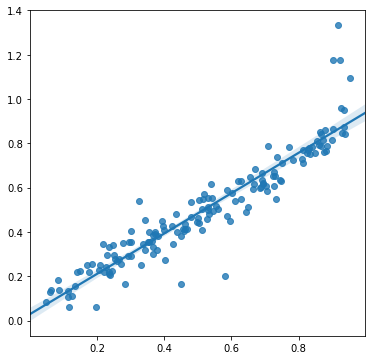

In [27]:
y_pred = model.predict(X_test)

plt.figure(figsize = (6,6))
sns.regplot(y_test, y_pred)
plt.show()

In [28]:
mae = mean_absolute_error(y_test, y_pred) #Średni błąd bezwzględny 
print(mae)

0.06515244603785553


# Uleprzenie modelu o kodowanie gorąco jedynkowe

In [29]:
all_data.groupby('Type 1').agg({"WinPercentage": "mean"}).sort_values(by = "WinPercentage")

,WinPercentage
Type 1,
Fairy,0.348344
Rock,0.404852
Steel,0.424529
Poison,0.433262
Ice,0.439604
Grass,0.440364
Bug,0.445328
Water,0.469357
Fighting,0.475616


Jak widać typ też wpływa na procent wygranych

In [30]:
one_hot_X = all_data.drop(['index', 'Name','SecondPokWin', 'FirstPokWin','TotalWin', 'TotalMatch'],axis =1)
one_hot_X['Legendary'] = one_hot_X['Legendary'].astype(str)
one_hot_X = pd.get_dummies(one_hot_X, drop_first = True)
one_hot_X.head(5)

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,FirstPokCombat,SecondPokCombat,WinPercentage,...,Type 2_Ground,Type 2_Ice,Type 2_NO TYPE,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Legendary_True
0,45,49,49,65,65,45,1,70.0,63.0,0.278195,...,0,0,0,0,1,0,0,0,0,0
1,60,62,63,80,80,60,1,55.0,66.0,0.380165,...,0,0,0,0,1,0,0,0,0,0
2,80,82,83,100,100,80,1,68.0,64.0,0.674242,...,0,0,0,0,1,0,0,0,0,0
3,80,100,123,122,120,80,1,62.0,63.0,0.560000,...,0,0,0,0,1,0,0,0,0,0
4,39,52,43,60,50,65,1,50.0,62.0,0.491071,...,0,0,1,0,0,0,0,0,0,0


In [31]:
one_hot_y = one_hot_X['WinPercentage']
one_hot_X.drop(['WinPercentage'], axis =1, inplace = True)

In [32]:
# Splitting 
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, one_hot_y, test_size = 0.2, random_state = 10)

In [33]:
scaler = StandardScaler() #Standaryzacja
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [34]:
model_2 = LinearRegression()
model_2.fit(X_train, y_train)
score = model_2.score(X_test, y_test)
print("Score: ", score)

Score:  0.8838584290264171


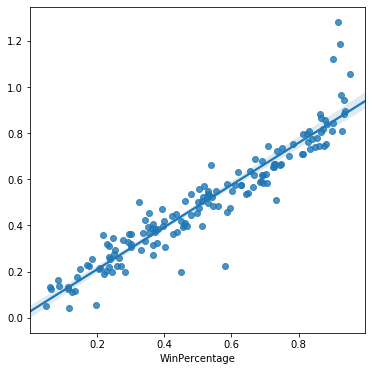

In [35]:
y_pred = model_2.predict(X_test)

plt.figure(figsize = (6,6))
sns.regplot(y_test, y_pred)
plt.show()

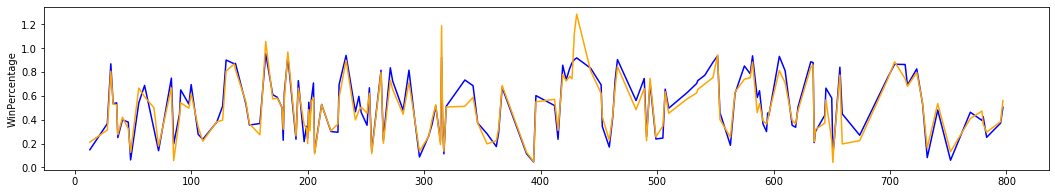

In [36]:
plt.figure(figsize = (18,3)) 
t =  pd.Series(y_test)
p =  pd.Series(y_pred)
sns.lineplot(x=t.index.values, y=t, color = 'blue')
sns.lineplot(x=t.index.values, y=p, color = 'orange')
plt.show()

> Powyższy wykres przedstawia zgodność testowych wyników z przewidzianymi przez model

***
***
***

# Inne modele

In [37]:
#Dane
col_name = ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation'] 
scale = StandardScaler()
X = all_data[col_name]
y = all_data.iloc[:, -1].values

# Splitting 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

#Standaryzacja
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## LinearSVR

In [38]:
from sklearn.svm import SVR
model_3 = SVR(kernel = 'linear')
model_3.fit(X_train, y_train)
print("Score:", model_3.score(X_test, y_test))

Score: 0.8639225722926185


In [39]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.06203821451958548

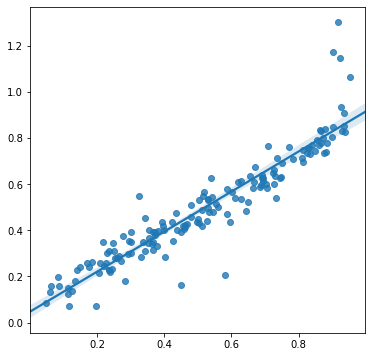

In [40]:
y_pred = model_3.predict(X_test)

plt.figure(figsize = (6,6))
sns.regplot(y_test, y_pred)
plt.show()

## DecisionTreeRegressor

In [41]:
from sklearn.tree import DecisionTreeRegressor
model_4 = DecisionTreeRegressor(random_state = 0)
model_4.fit(X_train, y_train)
print("Score: ", model_4.score(X_test, y_test))

Score:  0.8801367716421195


In [42]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.0691543644407056

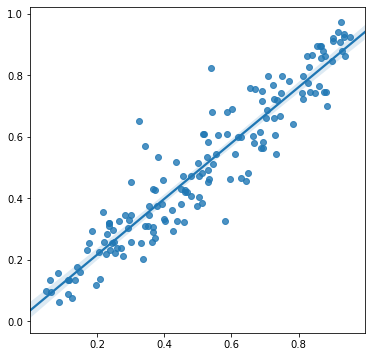

In [43]:
y_pred = model_4.predict(X_test)

plt.figure(figsize = (6,6))
sns.regplot(y_test, y_pred)
plt.show()

# Keras
### Przewidywanie walk pokemonów

In [44]:
import keras

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [45]:
combat.Winner[combat.Winner == combat.First_pokemon] = 0
combat.Winner[combat.Winner == combat.Second_pokemon] = 1

combat #który pokemon wygrał 0 = pierwszy, 1 = drugi 

,First_pokemon,Second_pokemon,Winner
0,266,298,1
1,702,701,1
2,191,668,1
3,237,683,1
4,151,231,0
...,...,...,...
49995,707,126,0
49996,589,664,0
49997,303,368,1
49998,109,89,0


In [46]:
pokemon['Legendary'] = pokemon['Legendary'].replace(True, 1)
pokemon['Legendary'] = pokemon['Legendary'].replace(False, 0)

In [47]:
type_df = pokemon.iloc[:, 0:4]
type_df = type_df.drop('Name', axis=1) 
type_dict = type_df.set_index('index').T.to_dict('list')

In [48]:
stats_df = pokemon.drop(['Type 1', 'Type 2', 'Name', 'Generation'], axis =1) # , 'Total_stats'
stats_dict = stats_df.set_index('index').T.to_dict('list')

In [49]:
diff_pok = combat
diff_pok['First_pokemon_stats'] = combat.First_pokemon.map(stats_dict)
diff_pok['Second_pokemon_stats'] = combat.Second_pokemon.map(stats_dict)

In [50]:
diff_pok

,First_pokemon,Second_pokemon,Winner,First_pokemon_stats,Second_pokemon_stats
0,266,298,1,"[50.0, 64.0, 50.0, 45.0, 50.0, 41.0, 0.0]","[70.0, 70.0, 40.0, 60.0, 40.0, 60.0, 0.0]"
1,702,701,1,"[91.0, 90.0, 72.0, 90.0, 129.0, 108.0, 1.0]","[91.0, 129.0, 90.0, 72.0, 90.0, 108.0, 1.0]"
2,191,668,1,"[55.0, 40.0, 85.0, 80.0, 105.0, 40.0, 0.0]","[75.0, 75.0, 75.0, 125.0, 95.0, 40.0, 0.0]"
3,237,683,1,"[40.0, 40.0, 40.0, 70.0, 40.0, 20.0, 0.0]","[77.0, 120.0, 90.0, 60.0, 90.0, 48.0, 0.0]"
4,151,231,0,"[70.0, 60.0, 125.0, 115.0, 70.0, 55.0, 0.0]","[20.0, 10.0, 230.0, 10.0, 230.0, 5.0, 0.0]"
...,...,...,...,...,...
49995,707,126,0,"[100.0, 120.0, 100.0, 150.0, 120.0, 90.0, 1.0]","[30.0, 40.0, 70.0, 70.0, 25.0, 60.0, 0.0]"
49996,589,664,0,"[60.0, 85.0, 40.0, 30.0, 45.0, 68.0, 0.0]","[35.0, 55.0, 40.0, 45.0, 40.0, 60.0, 0.0]"
49997,303,368,1,"[60.0, 50.0, 100.0, 85.0, 70.0, 65.0, 0.0]","[73.0, 115.0, 60.0, 60.0, 60.0, 90.0, 0.0]"
49998,109,89,0,"[40.0, 30.0, 50.0, 55.0, 55.0, 100.0, 0.0]","[25.0, 35.0, 70.0, 95.0, 55.0, 45.0, 0.0]"


In [51]:
def diff_stats(data):
    #roznica statystyk
    
    stats_col = ['HP_diff', 'Attack_diff', 'Defense_diff', 'Sp.Atk_diff', 'Sp.Def_diff', 'Speed_diff', 'Legendary_diff']
    diff_list = []

    for row in data.itertuples():
        diff_list.append(np.array(row.First_pokemon_stats) - np.array(row.Second_pokemon_stats))

    stats_df = pd.DataFrame(diff_list, columns=stats_col)
    data = pd.concat([data, stats_df], axis=1)
    data.drop(['First_pokemon_stats', 'Second_pokemon_stats'], axis=1, inplace=True)

    return data

In [52]:
dataset = diff_stats(diff_pok)
dataset

,First_pokemon,Second_pokemon,Winner,HP_diff,Attack_diff,Defense_diff,Sp.Atk_diff,Sp.Def_diff,Speed_diff,Legendary_diff
0,266,298,1,-20.0,-6.0,10.0,-15.0,10.0,-19.0,0.0
1,702,701,1,0.0,-39.0,-18.0,18.0,39.0,0.0,0.0
2,191,668,1,-20.0,-35.0,10.0,-45.0,10.0,0.0,0.0
3,237,683,1,-37.0,-80.0,-50.0,10.0,-50.0,-28.0,0.0
4,151,231,0,50.0,50.0,-105.0,105.0,-160.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...
49995,707,126,0,70.0,80.0,30.0,80.0,95.0,30.0,1.0
49996,589,664,0,25.0,30.0,0.0,-15.0,5.0,8.0,0.0
49997,303,368,1,-13.0,-65.0,40.0,25.0,10.0,-25.0,0.0
49998,109,89,0,15.0,-5.0,-20.0,-40.0,0.0,55.0,0.0


### Przygotowanie danych

In [53]:
y = dataset['Winner']
X = dataset.drop('Winner', axis=1)

In [55]:
X_tra, X_tes, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_tra)
X_test = scaler.fit_transform(X_tes)
X_train= np.array(X_train)
y_test = np.array(y_test)

In [56]:
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model

In [57]:
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras import models

model = models.Sequential()
model.add(Dense(30, input_dim=9, activation='tanh'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(20, activation='tanh'))#
model.add(Dense(20, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [58]:
his = model.fit(X_train, y_train)


Epoch 1/1
40000/40000 [==============================] - 10s 254us/step - loss: 0.2602 - accuracy: 0.9104


In [59]:
test_loss, test_acc = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 93us/step


In [60]:
print("Score:", test_acc)

Score: 0.9373000264167786


In [61]:
y_pred = model.predict(X_test)

([<matplotlib.axis.XTick at 0x7ff40407f7b8>,
 <a list of 2 Text xticklabel objects>)

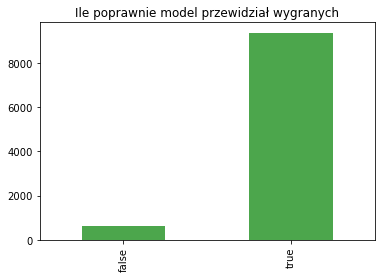

In [62]:
res = (y_pred.round().astype(int).reshape(1, -1)  == y_test)[0]
true = np.sum(res)
false = np.size(res) - np.sum(res)
bool_plot = pd.Series([false, true ])
bool_plot.plot(kind='bar', title="Ile poprawnie model przewidział wygranych",align='center', alpha=0.7, color='g')
plt.xticks([0,1], ('false', 'true'))

### Losowa walka ze zbioru testowego

In [63]:
from random import randint
rand = random.randint(0, y_test.shape[0]) 
p1 = X_tes.iloc[:, 0].values[rand]
p2 = X_tes.iloc[:, 1].values[rand]

Dwa pokemony: 

In [64]:
pokemon[pokemon['index'] == p1] #0

,index,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
319,320,Exploud,Normal,NaN,104,91,63,91,73,68,3,0.0


In [65]:
pokemon[pokemon['index'] == p2] #1

,index,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
481,482,Chingling,Psychic,NaN,45,30,50,65,50,45,4,0.0


In [67]:
print("Which pokemon win: {} true: {}".format( y_pred[rand].round().astype(int)[0], y_test[rand]))

Which pokemon win: 0 true: 0
